From https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/

In [3]:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  673k    0  673k    0     0   431k      0 --:--:--  0:00:01 --:--:--  431k


In [4]:
import pandas as pd
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)

In [35]:
data.shape

(24024, 2)

In [5]:
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4,9
2012-10-03 01:00:00,4,6
2012-10-03 02:00:00,1,1
2012-10-03 03:00:00,2,3
2012-10-03 04:00:00,6,1


In [9]:
data.columns = ['West', 'East']

In [13]:
data[data.isnull().any(axis=1)]

,West,East
Date,,
2013-03-10 03:00:00,NaN,NaN
2013-06-14 09:00:00,NaN,NaN
2013-06-14 10:00:00,NaN,NaN
2014-03-09 03:00:00,NaN,NaN
2015-03-08 03:00:00,NaN,NaN
2015-04-21 11:00:00,NaN,NaN
2015-04-21 12:00:00,NaN,NaN


In [14]:
data.fillna(0, inplace=True)
data[data.isnull().any(axis=1)]

,West,East
Date,,


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import numpy as np
from datetime import datetime

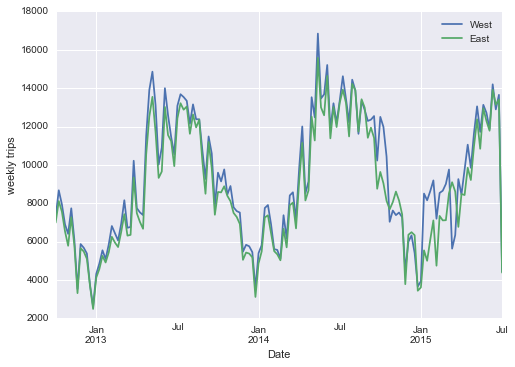

In [29]:
data.resample('W', how='sum').plot()
plt.ylabel('weekly trips');

In [30]:
pivoted = data.pivot_table(['East','West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

West                                      ... East                 \
             0   1  2  3  4   5    6    7    8    9  ...   14   15   16   17   
2012-10-03    4   4  1  2  6  21  105  257  291  172 ...   51   92  182  391   
2012-10-04    7   3  3  0  7  15   91  230  284  147 ...   56   74  161  353   
2012-10-05    4   4  4  2  7  18   68  218  251  131 ...   62   84  190  290   
2012-10-06    8  10  7  1  4   3   12   17   58   59 ...  114   96   76   73   
2012-10-07    6  12  2  4  1   6    9   14   43   67 ...  115  109   93   73   

                                      
             18   19  20  21  22  23  
2012-10-03  258   69  51  38  25  12  
2012-10-04  241  107  56  39  21  30  
2012-10-05  209   73  41  31  26  16  
2012-10-06   55   38  18  15  20  19  
2012-10-07   45   23  36  35   9  11  

[5 rows x 48 columns]

In [33]:
X = pivoted.values
X.shape

(1001, 48)

In [38]:
data.resample('D', how='sum').shape

(1001, 2)

In [39]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1001, 2)

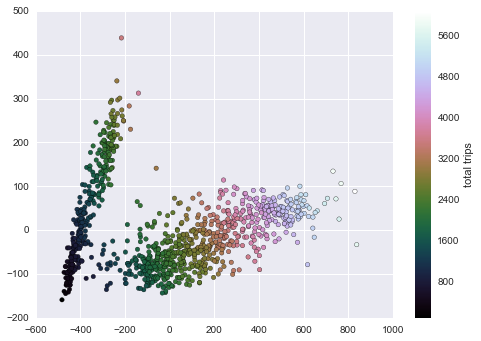

In [41]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap='cubehelix')
plt.colorbar(label='total trips')

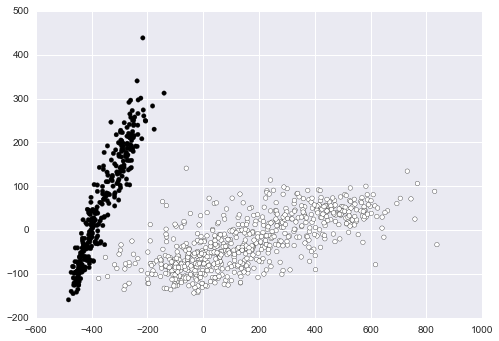

In [42]:
from sklearn.mixture import GMM
gmm = GMM(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label)

In [43]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Cluster
Date,,,
2012-10-03 00:00:00,4,9,0
2012-10-03 01:00:00,4,6,0
2012-10-03 02:00:00,1,1,0
2012-10-03 03:00:00,2,3,0
2012-10-03 04:00:00,6,1,0


In [45]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

West      East
Cluster                             
0       00:00:00  5.312139  6.213873
        01:00:00  2.713873  2.969653
        02:00:00  2.294798  1.732659
        03:00:00  1.570809  1.426301
        04:00:00  4.179191  2.650289

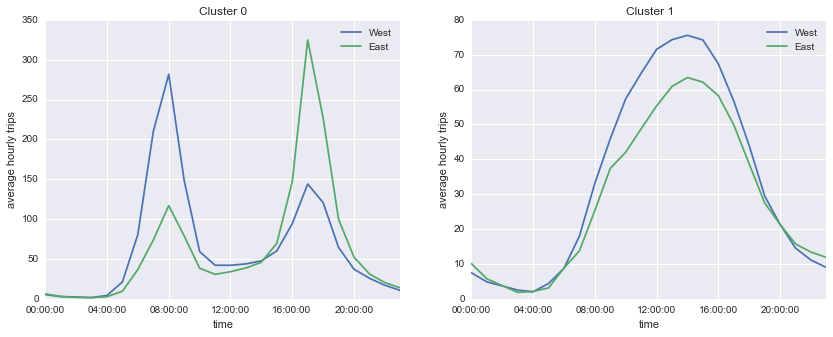

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

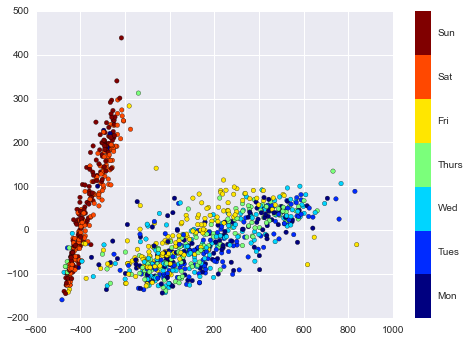

In [54]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
plt.clim(-0.5, 6.5)

In [56]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


In [58]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

0

In [61]:
results[(results['cluster'] == 0) & (results['is_weekend'])]

,cluster,is_weekend,weekday


In [69]:
results[(results.cluster == 0) & (results.is_weekend)]

,cluster,is_weekend,weekday


I like the .query syntax better!

In [62]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

23

In [63]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

In [64]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

In [70]:
holidays_all.name = 'holiday_name'  # required for join to work
joined = midweek_holidays.join(holidays_all)
set(joined['holiday_name'])

{'Christmas',
 'Day After Christmas',
 'Day After Thanksgiving',
 'Day Before Christmas',
 'July 4th',
 'Labor Day',
 'MemorialDay',
 'New Years Day',
 'Thanksgiving'}

In [71]:
joined.head()

,cluster,is_weekend,weekday,holiday_name
2012-11-22,1,False,Thu,Thanksgiving
2012-11-23,1,False,Fri,Day After Thanksgiving
2012-12-24,1,False,Mon,Day Before Christmas
2012-12-25,1,False,Tue,Christmas
2013-01-01,1,False,Tue,New Years Day


In [72]:
set(holidays) - set(joined.holiday_name)

{'Columbus Day',
 'Dr. Martin Luther King Jr.',
 'Presidents Day',
 'Veterans Day'}

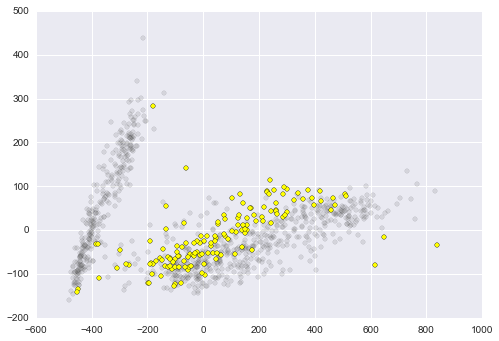

In [76]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow')

In [74]:
fridays

array([False, False,  True, ..., False, False, False], dtype=bool)

In [75]:
dayofweek

array([2, 3, 4, ..., 6, 0, 1], dtype=int32)

In [78]:
Xpca[:, 0].shape

(1001,)

In [79]:
Xpca[:, 1].shape

(1001,)

In [81]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] < -600)]
weird_fridays

Index([], dtype='object')

Previous should show us three Fridays in May that it turns out are bike to work days. For some reason, it's not. This bit was added to the blog post later, so perhaps the code's assuming something's set that's not actually set if you just follow it through from the beginning (I do that sometimes).